# [SIIM-FISABIO-RSNA COVID-19 Detection](https://www.kaggle.com/c/siim-covid19-detection)
> Identify and localize COVID-19 abnormalities on chest radiographs

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26680/logos/header.png)

In [1]:
# !pip install -q --upgrade seaborn

In [2]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
# import seaborn as sns

from time import time

In [3]:
dim = 512 #512, 256, 'original'
epochs = 40
batch_size = 32
fold_index = 4
model_name = 'yolov5x'

output_dir = '/mnt/siim-covid19/output/'
input_dir = '/mnt/siim-covid19/'
# output_dir = 'kaggle/working/'
# input_dir = 'kaggle/input/'


In [4]:
# Record running time
start_time = time()

# Prepare Dataset

In [5]:
def get_df_from_original_file():
    train_df = pd.read_csv(f'siim-covid19-yolov5-2class-labels/meta.csv')
    train_df['image_path'] = 'siimcovid19-512-jpg-image-dataset/train/'+train_df.image_id+'.jpg'
    # split
    gkf  = GroupKFold(n_splits = 5)
    train_df['fold'] = -1
    for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.StudyInstanceUID.tolist())):
        train_df.loc[val_idx, 'fold'] = fold
    train_df.head()
    return train_df

In [6]:
# Use saved file
train_df_path = '/mnt/siim-covid19/output/train_df_with_cur_loc.csv'
if (os.path.exists(train_df_path)):
    train_df = pd.read_csv(train_df_path)
else:
    train_df = get_df_from_original_file()

In [7]:
# move files and change records
os.makedirs(output_dir + 'siim-covid-19/labels/train', exist_ok = True)
os.makedirs(output_dir + 'siim-covid-19/labels/val', exist_ok = True)
os.makedirs(output_dir + 'siim-covid-19/images/train', exist_ok = True)
os.makedirs(output_dir + 'siim-covid-19/images/val', exist_ok = True)
label_dir = input_dir + 'siim-covid19-yolov5-2class-labels/labels/'

for index, row in tqdm(train_df.iterrows()):
    is_val = (row.fold == fold_index)
    file_path = row.image_path
    filename = file_path.split('/')[-1].split('.')[0]
    # This meta file has severe bug, including multiples of single image for a study, while 'id' is original and correct.
    if (filename + '_image' != row.id):
        continue
    # train_or_val = 'val' if is_val else 'train'
    if (is_val):
        target_path = output_dir + 'siim-covid-19/images/val/' + filename + '.jpg'
        if (file_path == target_path):
            continue
        shutil.move(file_path, target_path)
        shutil.copy(os.path.join(label_dir, filename+'.txt'), output_dir + 'siim-covid-19/labels/val')
    else:
        target_path = output_dir + 'siim-covid-19/images/train/' + filename + '.jpg'
        if (file_path == target_path):
            continue
        shutil.move(file_path, target_path)
        shutil.copy(os.path.join(label_dir, filename+'.txt'), output_dir + 'siim-covid-19/labels/train')
    # print(file_path)
    # print(target_path)
    train_df.loc[index, 'image_path'] = target_path

In [8]:
# Save train_df
train_df.to_csv(train_df_path)

# Get Class Name

In [9]:
class_ids  = {0:'opacity'}
class_names = ['opacity']

# YOLOv5 Training Meta File

In [10]:
from os import listdir
from os.path import isfile, join
import yaml

cwd = output_dir

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob(output_dir + 'siim-covid-19/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob(output_dir + 'siim-covid-19/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 1,
    names = class_names
    )

with open(join( cwd , 'siim-covid-19.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'siim-covid-19.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- opacity
nc: 1
train: /mnt/siim-covid19/output/train.txt
val: /mnt/siim-covid19/output/val.txt



# Prepare Yolov5

In [11]:
# !cp -r /kaggle/input/yolov5master-with-model-weights/yolov5-master /kaggle/working/
os.chdir('/mnt/siim-covid19/yolov5')
%pip install -qr requirements.txt # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)


detect: weights=['yolov5s.pt'], source=data/images/, imgsz=512, conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 2021-7-19 torch 1.9.0+cu102 CUDA:0 (GeForce RTX 2080 Ti, 11019.4375MB)

Fusing layers... 
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7266973 parameters, 0 gradients
image 1/2 /mnt/siim-covid19/

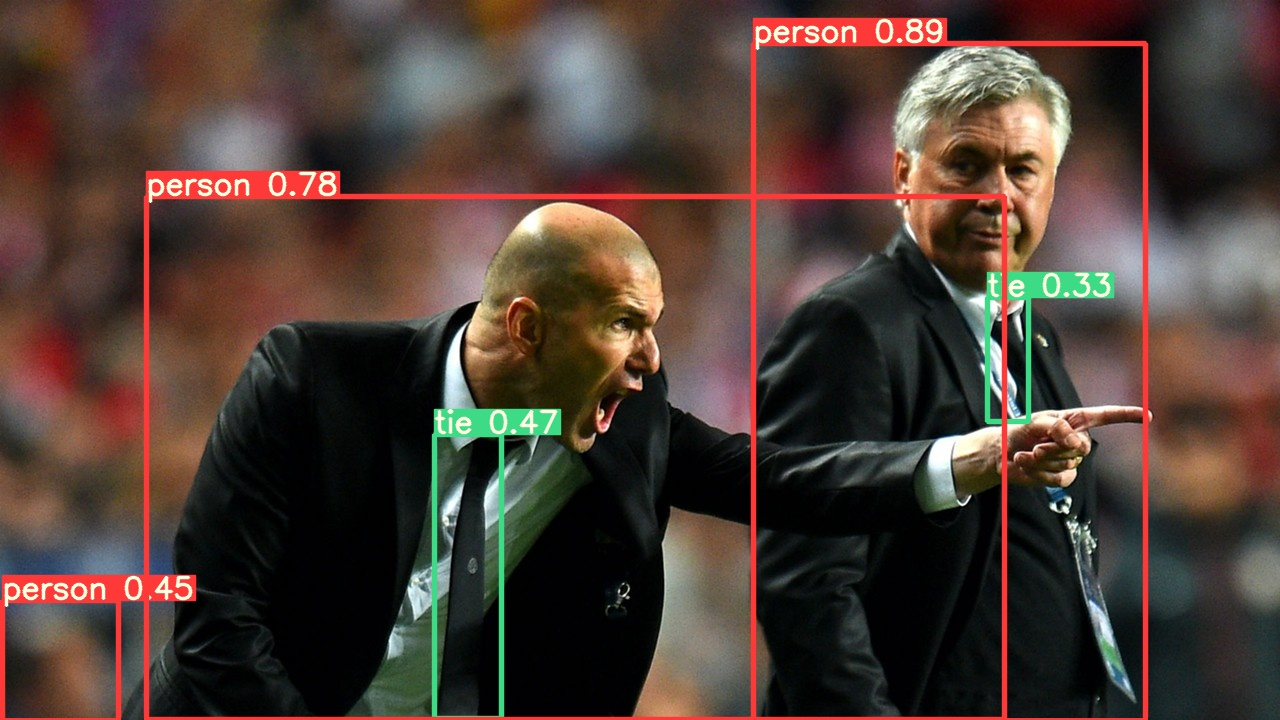

In [12]:
# %pip install -qr requirements.txt
!python detect.py --weights yolov5s.pt --img 512 --conf 0.25 --save-txt --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

## Pretrained Checkpoints:

| Model | AP<sup>val</sup> | AP<sup>test</sup> | AP<sub>50</sub> | Speed<sub>GPU</sub> | FPS<sub>GPU</sub> || params | FLOPS |
|---------- |------ |------ |------ | -------- | ------| ------ |------  |  :------: |
| [YOLOv5s](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 37.0     | 37.0     | 56.2     | **2.4ms** | **416** || 7.5M   | 13.2B
| [YOLOv5m](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 44.3     | 44.3     | 63.2     | 3.4ms     | 294     || 21.8M  | 39.4B
| [YOLOv5l](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 47.7     | 47.7     | 66.5     | 4.4ms     | 227     || 47.8M  | 88.1B
| [YOLOv5x](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | **49.2** | **49.2** | **67.7** | 6.9ms     | 145     || 89.0M  | 166.4B
| | | | | | || |
| [YOLOv5x](https://github.com/ultralytics/yolov5/releases/tag/v3.0) + TTA|**50.8**| **50.8** | **68.9** | 25.5ms    | 39      || 89.0M  | 354.3B
| | | | | | || |
| [YOLOv3-SPP](https://github.com/ultralytics/yolov5/releases/tag/v3.0) | 45.6     | 45.5     | 65.2     | 4.5ms     | 222     || 63.0M  | 118.0B

# Selecting Models
In this notebok I'm using `v5x`. To select your prefered model just replace `--cfg models/yolov5s.yaml --weights yolov5s.pt` with the following command:
* `v5s` : `--cfg models/yolov5s.yaml --weights yolov5s.pt`
* `v5m` : `--cfg models/yolov5m.yaml --weights yolov5m.pt`
* `v5l` : `--cfg models/yolov5l.yaml --weights yolov5l.pt`
* `v5x` : `--cfg models/yolov5x.yaml --weights yolov5x.pt`

In [13]:
print("Time elapsed: ", time() - start_time)

Time elapsed:  88.64124989509583


# Train

In [14]:
# !WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --nosave --cache 
weights_name = model_name + '.pt'
exp_name = model_name + '_fold_' + str(fold_index)
!WANDB_MODE="dryrun" python train.py --img $dim --batch $batch_size\
--epochs $epochs --cache --data ../output/siim-covid-19.yaml\
--weights $weights_name --name $exp_name

train: weights=yolov5x.pt, cfg=, data=../output/siim-covid-19.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=40, batch_size=32, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache_images=True, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=yolov5x_fold_4, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2021-7-19 torch 1.9.0+cu102 CUDA:0 (GeForce RTX 2080 Ti, 11019.4375MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, h

# Class Distribution

In [15]:
# plt.figure(figsize = (20,20))
# plt.axis('off')
# plt.imshow(plt.imread('runs/train/exp/labels_correlogram.jpg'));

In [16]:
# plt.figure(figsize = (20,20))
# plt.axis('off')
# plt.imshow(plt.imread('runs/train/exp/labels.jpg'));

# Batch Image

In [17]:
# import matplotlib.pyplot as plt
# plt.figure(figsize = (15, 15))
# plt.imshow(plt.imread('runs/train/exp/train_batch0.jpg'))

# plt.figure(figsize = (15, 15))
# plt.imshow(plt.imread('runs/train/exp/train_batch1.jpg'))

# plt.figure(figsize = (15, 15))
# plt.imshow(plt.imread('runs/train/exp/train_batch2.jpg'))

# GT Vs Pred

In [18]:
# fig, ax = plt.subplots(3, 2, figsize = (3*5,4*5), constrained_layout = True)
# for row in range(3):
#     ax[row][0].imshow(plt.imread(f'runs/train/exp/test_batch{row}_labels.jpg'))
#     ax[row][0].set_xticks([])
#     ax[row][0].set_yticks([])
#     ax[row][0].set_title(f'test_batch{row}.jpg', fontsize = 12)
    
#     ax[row][1].imshow(plt.imread(f'runs/train/exp/test_batch{row}_pred.jpg'))
#     ax[row][1].set_xticks([])
#     ax[row][1].set_yticks([])
#     ax[row][1].set_title(f'test_batch{row}.jpg', fontsize = 12)

# (Loss, Map) Vs Epoch

In [19]:
# plt.figure(figsize=(30,15))
# plt.axis('off')
# plt.imshow(plt.imread('runs/train/exp/results.png'));

# Confusion Matrix

In [20]:
# plt.figure(figsize=(30,15))
# plt.axis('off')
# plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

# Precision, Recall, Precision-Recall, F1 Curve

In [21]:
# plt.figure(figsize=(2*10, 2*8))
# for idx, tag in enumerate(['P', 'R', 'PR', 'F1']):
#     plt.subplot(2, 2, idx+1)
#     plt.imshow(plt.imread(f'runs/train/exp/{tag}_curve.png'));
#     plt.axis('OFF')
#     plt.title(tag, fontsize=15)
# plt.tight_layout()
# plt.show()

# Output Saved Model

In [22]:
!cp /mnt/siim-covid19/yolov5/runs/train/{exp_name}/weights/best.pt /mnt/siim-covid19/output/weights/{exp_name}.pt

# Inference Example

In [23]:
# !python detect.py --weights /kaggle/working/best.pt --img 640 --conf 0.25 --save-txt --source siimcovid19-512-jpg-image-dataset/train/000c3a3f293f.jpg
# # Image(filename='/kaggle/input/siimcovid19-512-jpg-image-dataset/train/000c3a3f293f.jpg')

# Removing Files

In [24]:
# !rm -rf /mnt/siim-covid19/output/siim-covid-19
# !rm -rf /kaggle/working/yolov5-master
# for file in (glob('**/*.png', recursive = True)+glob('**/*.jpg', recursive = True)):
#     os.remove(file)

In [25]:
print("Time elapsed: ", time() - start_time)

Time elapsed:  4498.583623409271
